# Import Packages

In [3]:
import pandas as pd
import numpy as np

import sys,os
import time
from datetime import datetime
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels
from statsmodels.tsa.stattools import adfuller
from scipy.stats import poisson 
from scipy.stats import chisquare

from lifetimes import BetaGeoFitter,ModifiedBetaGeoFitter,GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes.generate_data import modified_beta_geometric_nbd_model
from lifetimes.plotting import plot_period_transactions,plot_calibration_purchases_vs_holdout_purchases

from sklearn.metrics import roc_curve,auc,classification_report,f1_score,mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows=500

In [4]:
df = pd.read_csv('data.csv')
df.shape

(49945, 3)

> The file contains approximately 50,000 transactions from an ecommerce store that sells widgets. Each row represents a purchase. The first column is the CustomerID and it’s possible to have multiple rows with the same CustomerID . The second column is a UTC timestamp of the transaction and the third column is the monetary value of the transaction.

# Basic Exploration

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timestamp'] = df['Timestamp'].apply(lambda x:datetime.replace(x,tzinfo=None))
df = df.sort_values(['CustomerID','Timestamp'])

In [6]:
df.head()

,CustomerID,Timestamp,PurchaseValue
10498,0001117ff1305c1fe840697166e61564,2016-12-27 21:05:00,88.25
9715,0001117ff1305c1fe840697166e61564,2017-01-07 15:14:00,87.28
7651,00028502859fd7e111d88c20456b59d5,2016-12-29 17:30:00,78.10
13677,000306d200fd6e9b03de48d15348f5c2,2017-11-03 11:32:00,98.44
5047,0003f3458a6e7b495a975c2d9ddda559,2016-12-28 22:14:00,68.28


In [7]:
# checking for nulls
df.isnull().sum()

CustomerID       0
Timestamp        0
PurchaseValue    0
dtype: int64

In [8]:
df.Timestamp.describe()

count                   49945
unique                  44795
top       2017-03-30 14:27:00
freq                       16
first     2016-11-30 04:47:00
last      2017-12-06 17:53:00
Name: Timestamp, dtype: object

# Creating RFM dataframe 

A RFM matrix contain the following attributes for each customer:

* **T** is the length of the period of observation for the customer based on the value used for freq (the default is frequency is day). This can also be thought of the length of time between a customer’s first purchase and the end of the period, measured in increments defined by freq.
* **recency** is the point (relative to their own period of observation) at which the customer made their most recent repeat purchase. This can also be thought of the length of time between a customer’s first and last purchase for the period, measured in increments defined by freq.
* **frequency** is the number of repeat purchases the customer made during the observation period.
* **monetary_value** is the average monetary amount of each repeat purchase made by a customer.

In [9]:
data = summary_data_from_transaction_data(df, 'CustomerID', 'Timestamp', monetary_value_col='PurchaseValue')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000
000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000
0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000


In [10]:
print(f"Total number of customers: {data.shape[0]}")
print("============================================")
print("Purchase frequency summary:")
print(data['frequency'].describe())
print("============================================")
print(f"Number of customers with only one purchase: {round(100*sum(data['frequency'] == 0)/float(len(data)))}%")

Total number of customers: 23708
Purchase frequency summary:
count    23708.000000
mean         1.025477
std          2.111326
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         95.000000
Name: frequency, dtype: float64
Number of customers with only one purchase: 59%


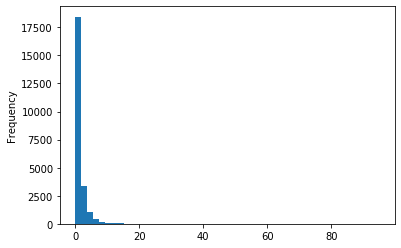

In [11]:
data['frequency'].plot(kind='hist', bins=50);

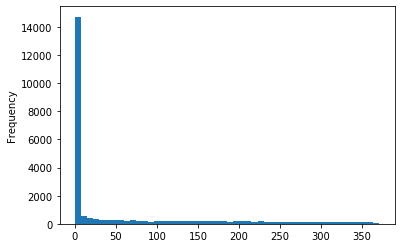

In [12]:
data['recency'].plot(kind='hist', bins=50);

# Implement the modified BG model 

Link to the Paper: http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf

In [13]:
for value in [0.001,0.01,0.1,0]:
    bgf = ModifiedBetaGeoFitter(penalizer_coef=value)
    #bgf.fit(data['frequency'], data['recency'], data['T'])

    holdout_data = calibration_and_holdout_data(df, 
                                                   'CustomerID', 
                                                   'Timestamp', 
                                                   calibration_period_end=pd.to_datetime('2017-09-07')) 
    bgf.fit(holdout_data['frequency_cal'], holdout_data['recency_cal'], holdout_data['T_cal'])
    duration_holdout=90
    holdout_data["model_predictions"] = bgf.conditional_expected_number_of_purchases_up_to_time(duration_holdout, 
                                                                                              holdout_data["frequency_cal"], 
                                                                                              holdout_data["recency_cal"], 
                                                                                              holdout_data["T_cal"])
    print(f"Results for Penalizer Coef = {value}")
    print("============================================")
    print(f"RMSE: { np.sqrt(mean_squared_error(holdout_data.frequency_holdout,holdout_data.model_predictions)) }")
    print(f"MAE: {mean_absolute_error(holdout_data.frequency_holdout,holdout_data.model_predictions)}")
    #print(plot_calibration_purchases_vs_holdout_purchases(bgf, holdout_data, n=10))
    print("============================================")
    

Results for Penalizer Coef = 0.001
RMSE: 0.784688298565694
MAE: 0.47601167929563687
Results for Penalizer Coef = 0.01
RMSE: 0.7882827209452978
MAE: 0.48508024773291425
Results for Penalizer Coef = 0.1
RMSE: 0.8167408690864871
MAE: 0.5284833934830944
Results for Penalizer Coef = 0
RMSE: 0.7858345571565305
MAE: 0.4753318361045578


> Just a grid search of penalizer coef shows that value of 0.001 is better in case of RMSE and value 0 is better for MAE. I am going to just use penalizer_coef=0 for this exercise.

In [14]:
bgf = ModifiedBetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.ModifiedBetaGeoFitter: fitted with 23708 subjects, a: 0.54, alpha: 85.27, b: 1.45, r: 0.79>


## Listing the 100 customers predicted to make the most purchases over the next 12 months.

> Use the fitted modified BG model to estimate the expected number of purchases by the customer with given history. 

In [15]:
t = 365
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
top_100_customers_by_expected_purchases = data.sort_values(by='predicted_purchases',ascending=False).head(100)

In [16]:
top_100_customers_by_expected_purchases.loc[:,'predicted_purchases']

CustomerID
a5fadc51b1ae844ad9a70ad3cfa46a64    64.472898
48a503edbaded96a3be27deee11967a1    30.920429
9f447f9415a380ac2eeee7df49c6ee7e    25.950894
5f01420f0edda6555df5ce1cc62b986c    25.056529
8d2ce54737dd404d20cadf1405d46dc8    22.918299
a62a17bb46864da2c6da691d838971b3    20.753380
3b11478939967e896ae2619615650f97    20.734257
2ad9a83ee23110d8c2f4c01600b94f20    19.942978
75fda9ea22086bf3814ff8c3f53de8ca    19.602512
30aa99d3357244cf38ca04eadef1473a    18.891188
5ac5ed64cd99ed2a8403b7a927e644ef    17.918448
a719d6643a7832535de9aded2f467825    17.748813
a1c8d419a97af1f7152e21c0dddfcbce    16.515711
cdf642859ae8d9a1e489c3a655cba827    16.322381
ed2b4332b3ca253cfbb0ffb54d3f5ae0    16.258608
880474a82e33389ae7f377b2ea35bbdd    15.678406
ca2202a96c2de6ca6b8a37a4a73fa730    15.618740
16134915d822fe17588ae585935e1e81    15.293520
f6a4f156c817ecb376d678f2aafdc570    15.255699
742d5a52d4df7cb14246d7f390de5d8a    14.485388
e675875db3648ab4dbbd52768296425c    14.309883
663b3df249f614305792ec7

## Listing the 100 customers predicted to spend the most over the next 12 months

> We can fit gamma-gamma model to our data, to predict likely spend per transaction in the future at the customer level. We can only consider only customers who has made at least one repurchase. We need to remove one-off customers since ther monetary value is zero 
> Then we can use our fitted bgf model to predict expected purchases and capture CLV at customer level to get the customers with most spend in next 12 months

In [17]:
customers_with_valid_mv = data.loc[data['frequency']>0].copy()

In [18]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(customers_with_valid_mv['frequency'],customers_with_valid_mv['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 9647 subjects, p: 4.57, q: 3.65, v: 135.88>


In [19]:
top_100_customers_by_expected_spend = ggf.customer_lifetime_value(
    bgf,
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12
).sort_values(ascending=False).head(100)

In [20]:
top_100_customers_by_expected_spend

CustomerID
a5fadc51b1ae844ad9a70ad3cfa46a64    25936.659045
ca2202a96c2de6ca6b8a37a4a73fa730    19138.347625
dca76db00cc59dfbcdcc97c8bbc7f9f1    11086.783762
5ac5ed64cd99ed2a8403b7a927e644ef    10300.620674
60c19a709e3ced2d16d7100eb1069df5     9031.054772
98f8e41f45721cbe49a3147f6cf62432     7066.549715
5f01420f0edda6555df5ce1cc62b986c     6944.893982
a92534133444b5028d12a129b1b128f7     6801.786015
089ecc49200cfe79584d0bec2a3cf8c0     6752.043094
742d5a52d4df7cb14246d7f390de5d8a     6710.081606
eba458987dc67827871c1d4d92e646e1     6549.315901
a719d6643a7832535de9aded2f467825     6522.095586
ed2b4332b3ca253cfbb0ffb54d3f5ae0     6497.956574
48a503edbaded96a3be27deee11967a1     6342.006690
9cb19c3fc7311aae01cf16571b528001     6319.464955
922bdaa119d44065b17b0447255646ae     6308.737323
24f05bfab01fef56ec049a828ebe20ab     6213.942236
66162981fc95e268e45bbfc738059687     6155.055107
30aa99d3357244cf38ca04eadef1473a     6024.579161
cd4cb9ec252a085ed4d2d3af7c18280a     5958.049446
a62a17bb4

# Exploring the statistical assumptions that the model makes and checking if they are valid for a model of a customer buying widgets from an ecommerce store?

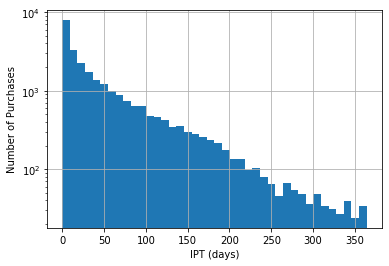

In [21]:
inter_purchase_times = df.groupby('CustomerID')['Timestamp'].diff().apply(lambda x: x.days)
inter_purchase_times.hist(bins=40)
plt.yscale('log');
plt.xlabel('IPT (days)') ;
plt.ylabel('Number of Purchases') ;

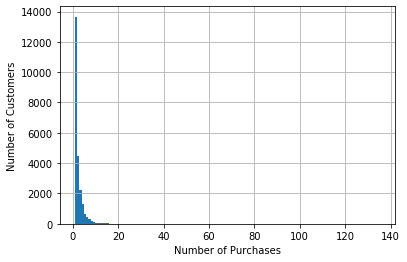

In [22]:
n_purchases = df.groupby(['CustomerID']).size()
n_purchases.hist(bins=(n_purchases.max(axis=0) - n_purchases.min(axis=0)) + 1)
plt.xlabel('Number of Purchases') ;
plt.ylabel('Number of Customers');

## The first assumption of BG model is that the number of purchases made by a customer follows a poisson process with rate lambda. In other words, the time between the purchases are exponentially distributed with rate lambda.  
> Yes, all customers are not same. some customers might be looking for new widgets all the time and others might buy from time to time. It makes more sense to have a distribution for each customer the transaction rate lambda, rather than assuming that a single lambda for all the customers

## The second assumption is that the purchase rates follow a gamma distribution
> Gamma distribution is perfect because the purchase rate lambda is a positive value for all customers and most of the customers would buy widgets at a similar rate and right skewed as only few customers buy often. Gamma distribution is generally suitable prior for positive parameters  

## Third Assumption: After any purchase, a customer becomes inactive with probability p. The point at which the customer becomes inactive is distributed across transactions according to a geometric distribution
> After everytime a customer buys a widget from our ecommerce website, for next time he/she will onsider the changes in price, quality and variety since his/her last visit, and then decide whether to purchase again next time, or look for another website. So this assumption of a customer becoming inactive after any purchase holds good.
> Gamma distribution models How many failures until a success? here success can be seen as customer becoming inactive. So at each purchase the customer was active for all the purchases before and has a probability of p becoming inactive after current purchase. Also, since there is no limit on number of purchases by a customer and probability of becoming inactive doesn't change after each purchase geometric is best suited.

## Fourth Assumption: The probability of becoming inactive, p , for all customers follows beta distribution
> Again the customers vary widely, so it makes sense to have different probability p for each customer. Some customers might be looking for one widget, they buy and leave, and some might be constantly looking for widgets all the time. We need to have distribution that is flexible. Beta distribution is flexible and best suited to model probabilities (since they have range [0,1])

## Fifth Assumption: Modified BG model has one more assumption, which is the customers have additional probability to become inactive after first purchase. This helps in modeling zero repurchasers 
>This addition tries to model the customer behaviour close to reality. For the current porblem we cans ee that ~60% are zero repurchasers , meaning have bought only once in the past year. So, Modified BG model suits to model our widget purchase problem

## Checking if assumptions are true for the given data

We check for two assumptions in the following cells
>* To see if customer purchase pattern follows a poisson distribution. We use chi-square test, where we calculate purchase rate for a customer and sample random poisson process using that rate. Then we create observed and expected frequency tables for number of purchases and test the hypothesis. If data is too small and if count for each bin is small then this test is invalid.
>* To see if average purchase value is stable over time. We use Augmented Dickey-Fuller Test, where we check if there is a correlation between the lags of the purchase time-series.

In [23]:
def ADF_Stationarity_Test(timeseries, printResults = True):
    """
    
    Test if given timeseries is stationary or not.
    Uses Augmented Dickey-Fuller Test.
    H0: there is presence of unit root
    Ha: The time-series is stationary

    Parameters
    ----------
    ts_df : numpy array 
        the timeseries to be checked
    printResults : Boolean, Optional
        Should the results of ADF test to be printed or not

    Returns
    -------
    int
        1 if stationary else 0 and -1 if error

    """
    
    #Dickey-Fuller test:
    try:
        adfTest = adfuller(timeseries, autolag='AIC')
    except Exception as e:
        return(-1)
    
    pValue = adfTest[1]
        
    if (pValue<.05):
        isStationary = 1
        #print("p-value is less than significance level, time series is stationary")
    else:
        isStationary = 0
        #print("p-value is greater than significance level, time series is non-stationary")
        
    if printResults:
        dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

        #Add Critical Values
        for key,value in adfTest[4].items():
            dfResults[f'Critical Value {key}'] = value

        #print('Augmented Dickey-Fuller Test Results:')
        #print(dfResults)
    
    return(isStationary)

def plot_ts(ts_df):
    """
    
    Custom function to plot timeseries

    Parameters
    ----------
    ts_df : dataframe 
        should have 'Timestamp' & 'PurchaseValue' fields

    Returns
    -------
    Prints a time series plot

    """
    ts_df['Timestamp'] = pd.to_datetime(ts_df['Timestamp'])
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(ts_df.Timestamp, ts_df.PurchaseValue)
    fig.autofmt_xdate()
    
def get_ordered_customer_data(customer):
    """
    
    Custom function to get ordered time series
    of purchases for a customer

    Parameters
    ----------
    customer : string 
        Customer ID 

    Returns
    -------
    Dataframe
        with gap filled and ordered purchase time series for a customer

    """

    cust_df = df.loc[df.CustomerID==customer].copy()
    cust_df['Timestamp'] = cust_df['Timestamp'].dt.date
    ts_df = pd.DataFrame({'Timestamp':pd.date_range(cust_df.Timestamp.min(),cust_df.Timestamp.max())})
    ts_df['Timestamp'] = ts_df['Timestamp'].dt.date
    ts_df = ts_df.merge(cust_df,on='Timestamp',how='left')
    ts_df['CustomerID'].fillna(customer,inplace=True)
    ts_df.PurchaseValue.fillna(0,inplace=True)
    ts_df.loc[:,'is_purchase'] = np.where(ts_df['PurchaseValue']>0,1,0)
    
    return(ts_df)

def custom_chisq_test(comparison_df):
    
    """
    
    Test if purchases of a customer is poisson distributed
    Uses chi-square Test.
    H0: The observed frequencies for a variable match the expected frequencies
    Ha: The observed frequencies for a variable doesn't match the expected frequencies and 
        they are form different distributions

    Parameters
    ----------
    comparison_df : dataframe, with observed and expected frequencies

    Returns
    -------
    int
        1 if poisson distributed else 0

    """
    
    statistic,p_value = chisquare(comparison_df.Observed, f_exp=comparison_df.Expected)
    
    if p_value<0.05:
        IsPoisson = 0
    else:
        IsPoisson = 1
        
    return(IsPoisson)
    
    

In [24]:
all_customers = np.unique(df[df.groupby('CustomerID')['Timestamp'].transform('size') >= 5]['CustomerID']).tolist()
#all_customers = np.unique(df.CustomerID.values).tolist()
assumption_results = pd.DataFrame({'Customer':all_customers})
assumption_results.loc[:,'isStationary'] = 0
assumption_results.loc[:,'isPoisson'] = 0

In [25]:
for customer in all_customers:
    
    #Stationarity test
    ts_df = get_ordered_customer_data(customer)
    purchaseSeries = ts_df.sort_values('Timestamp')['PurchaseValue'].values
    assumption_results.loc[assumption_results.Customer==customer,'isStationary'] = ADF_Stationarity_Test(purchaseSeries,printResults=False)
    
    #Poisson Process test
    grp = ts_df.groupby('Timestamp').agg({'is_purchase':'sum'}).reset_index()
    lam = grp.is_purchase.mean()
    
    observed_df = grp.groupby('is_purchase').size().reset_index()
    observed_df.columns = ['n_purchase','Observed']
    
    expected= pd.DataFrame({'Expected':poisson.rvs(mu=lam,size=len(ts_df))})
    expected_df = expected.groupby('Expected').size().reset_index()
    expected_df.columns = ['n_purchase','Expected']
    
    comparison_df = observed_df.merge(expected_df,on='n_purchase',how='inner')
    assumption_results.loc[assumption_results.Customer==customer,'isPoisson'] = custom_chisq_test(comparison_df)
    
    

In [26]:
print(f"Total Number of customers checked: {len(assumption_results)}")
print(f"Number of Customers where the poisson distribution assumption fails:\
 {assumption_results.loc[assumption_results['isPoisson']==0].shape[0]}")
print(f"Number of Customers where the stationarity assumption fails:\
 {assumption_results.loc[assumption_results['isStationary']==0].shape[0]}")
print(f"Number of Customers Test failed:\
 {assumption_results.loc[assumption_results['isStationary']==-1].shape[0]}")

Total Number of customers checked: 2067
Number of Customers where the poisson distribution assumption fails: 190
Number of Customers where the stationarity assumption fails: 167
Number of Customers Test failed: 0


> Checking for the assumptions, most(~90%) of the customers have poisson distributed purchases and purchase value is stationary over time

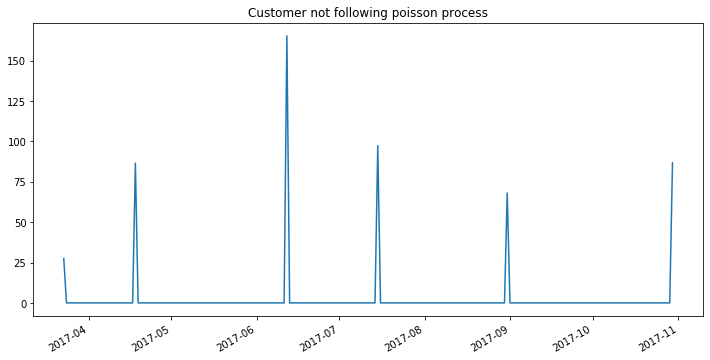

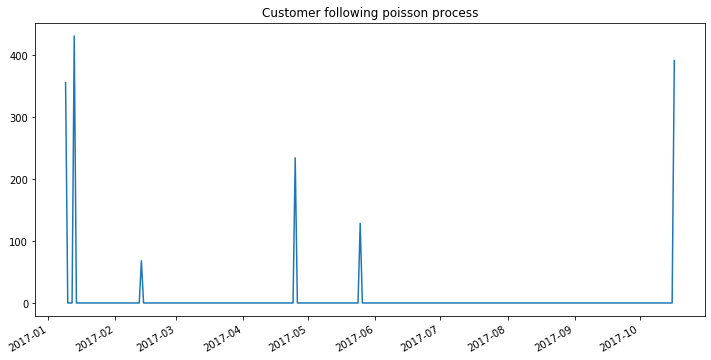

In [27]:
customer_1 = assumption_results.loc[assumption_results['isPoisson']==0,'Customer'].sample(n=1).values[0]
customer_2 = assumption_results.loc[assumption_results['isPoisson']==1,'Customer'].sample(n=1).values[0]
plot_ts(get_ordered_customer_data(customer_1))
plt.title("Customer not following poisson process");
plot_ts(get_ordered_customer_data(customer_2))
plt.title("Customer following poisson process");

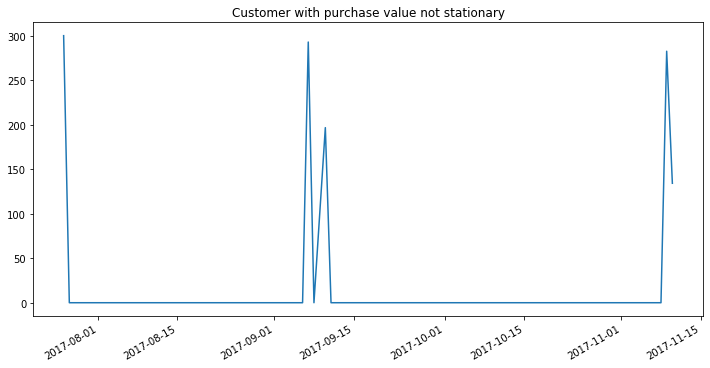

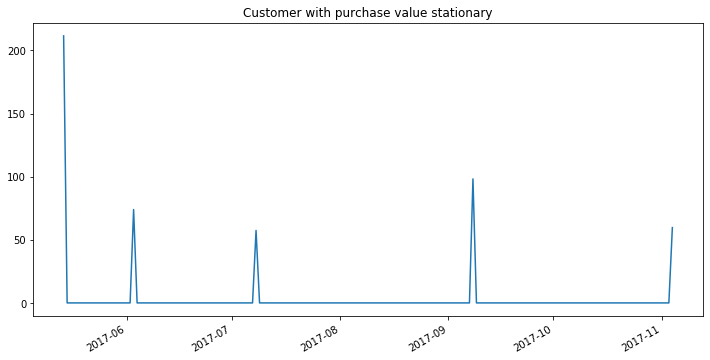

In [28]:
customer_1 = assumption_results.loc[assumption_results['isStationary']==0,'Customer'].sample(n=1).values[0]
customer_2 = assumption_results.loc[assumption_results['isStationary']==1,'Customer'].sample(n=1).values[0]
plot_ts(get_ordered_customer_data(customer_1))
plt.title("Customer with purchase value not stationary");
plot_ts(get_ordered_customer_data(customer_2))
plt.title("Customer with purchase value stationary");

# Simulation

Writing a simulation that shows how many customers are alive after 10 days, 1 year, 10 years and 100 years and how many purchases they have made in that time using the modified BG model.

Model Parameters from our earlier fitted model
>* a     = 0.54
>* alpha = 85.27 (1/scale of gamma)
>* b     = 1.45
>* r     = 0.79 (shape of gamma)

We have purchase rate of all customers distributed by gamma(shape=0.79,scale=0.012) and probability of becoming inactive distributed by Beta(a=0.54,b=1.45)

In [29]:
def expand_grid(dct):
    """Custome function to create a dataframe using combinations of different lists"""
    
    rows = itertools.product(*dct.values())
    return pd.DataFrame.from_records(rows, columns=dct.keys())

In [30]:
number_of_days_in_a_year = 365
number_of_days_in_a_month = 30
number_of_days_in_a_week = 7
#parameters found by our model
r = bgf.params_.r
alpha = bgf.params_.alpha
a = bgf.params_.a
b = bgf.params_.b

def simulation(number_of_customers,lambdas,probs,time_period=10,freq='days'):
    """ Simulation function that simualtes purchases for a customer based on the parameters from fitted bgf model"""
   
    #to get the frequency right
    if freq == 'years':
        time_period = time_period*number_of_days_in_a_year
    if freq == 'months':
        time_period = time_period*number_of_days_in_a_month
    if freq == 'weeks':
        time_period = time_period*number_of_days_in_a_week
    
    start=1
    number_of_active_customers=np.zeros(number_of_customers)
    number_of_purchases=np.zeros(number_of_customers)
    
      #results = expand_grid(
        #{'customer': range(1,number_of_customers+1,1),
         #'time_period': range(1, time_period+1, 1),
         #'purchase': [0]}
        #)
    
    #for each of 100 random customers
    for i in range(number_of_customers):
        
        # simulate a exponential time using the randomly sampled purchase rate
        # using ceil to give an interger number of days. 
        next_purchase_time = np.ceil(np.random.exponential(scale=1.0 / lambdas[i]))
        
        # Decide if the customer is active or not after the purchase
        active = np.random.random() > probs[i]
        
        # if active, and the next purchase period is before time period ends add the purchase 
        # and simulate next purchase
        #The loop ends, if either customer is inactive or is alive but purchases only after set observation period
        while next_purchase_time <= time_period and active:
            
            #results.loc[(results.customer==(i+1))&(results.time_period==(next_purchase_time+start)),'purchase'] = 1
            number_of_purchases[i]+=1
            next_purchase_time += np.ceil(np.random.exponential(scale=1.0 / lambdas[i]))
            active = np.random.random() > probs[i]
           
        
        # record here if customer is active or not
        if active:
            number_of_active_customers[i]+=1
            
    # total up all the purchases from all customers
    #number_of_purchases = results['purchase'].sum()
    
    return(number_of_purchases,number_of_active_customers)

In [31]:
number_of_customers=100
# use the fitted parameters from the bgf model to simualate transaction rate
# and p_alive for n customers
lambdas = np.random.gamma(shape=r, scale=1/alpha, size=number_of_customers)
probs = np.random.beta(a,b,size=number_of_customers)
number_of_simulations = 1
results_dict = {}

In [32]:
%%time
for n in range(number_of_simulations):
    number_of_purchases1,number_of_active_customers1 = simulation(number_of_customers,lambdas,probs,time_period=10,freq='days')
    number_of_purchases2,number_of_active_customers2 = simulation(number_of_customers,lambdas,probs,time_period=1,freq='years')
    number_of_purchases3,number_of_active_customers3 = simulation(number_of_customers,lambdas,probs,time_period=10,freq='years')
    number_of_purchases4,number_of_active_customers4 = simulation(number_of_customers,lambdas,probs,time_period=100,freq='years')
    results_dict[n+1] = [number_of_purchases1.sum(),number_of_active_customers1.sum(),
                        number_of_purchases2.sum(),number_of_active_customers2.sum(),
                        number_of_purchases3.sum(),number_of_active_customers3.sum(),
                        number_of_purchases4.sum(),number_of_active_customers4.sum()]

CPU times: user 73 ms, sys: 2.24 ms, total: 75.2 ms
Wall time: 94.2 ms


In [33]:
simulation_results = pd.DataFrame(results_dict.items())
simulation_results.columns = ['SimualtionID','results']
simulation_results[['n_purchases_10_days','n_active_10_days','n_purchases_1_years','n_active_1_years',
                   'n_purchases_10_years','n_active_10_years','n_purchases_100_years','n_active_100_years']] \
                    = pd.DataFrame(simulation_results.results.values.tolist(), index= simulation_results.index)
simulation_results.drop('results',axis=1,inplace=True)

In [34]:
print(f"Number of customers: {number_of_customers}\nNumber of simulations: {number_of_simulations}")
print("=====================================================")
print(f"Number of purchases made by the customers after 10 days: {simulation_results.n_purchases_10_days.mean()}")
print(f"Number of active customers after 10 days: {simulation_results.n_active_10_days.mean()}")
print("=====================================================")
print(f"Number of purchases made by the customers after 1 years: {simulation_results.n_purchases_1_years.mean()}")
print(f"Number of active customers after 1 years: {simulation_results.n_active_1_years.mean()}")
print("=====================================================")
print(f"Number of purchases made by the customers after 10 years: {simulation_results.n_purchases_10_years.mean()}")
print(f"Number of active customers after 10 years: {simulation_results.n_active_10_years.mean()}")
print("=====================================================")
print(f"Number of purchases made by the customers after 100 years: {simulation_results.n_purchases_100_years.mean()}")
print(f"Number of active customers after 100 years: {simulation_results.n_active_100_years.mean()}")
print("=====================================================")

Number of customers: 100
Number of simulations: 1
Number of purchases made by the customers after 10 days: 10.0
Number of active customers after 10 days: 72.0
Number of purchases made by the customers after 1 years: 185.0
Number of active customers after 1 years: 49.0
Number of purchases made by the customers after 10 years: 787.0
Number of active customers after 10 years: 21.0
Number of purchases made by the customers after 100 years: 5584.0
Number of active customers after 100 years: 11.0


## Using generate data from lifetimes package
> Easier way to simulate data based on modified BG model. The difference between the previous function and below is here, for different time period simulation you sample diffrent customers. Both methods should converge, if run for more number of simulation

In [35]:
b1 = modified_beta_geometric_nbd_model(T=10, r=r, alpha=alpha, a=a, b=b, size=100)
b2 = modified_beta_geometric_nbd_model(T=1*number_of_days_in_a_year, r=r, alpha=alpha, a=a, b=b, size=100)
b3 = modified_beta_geometric_nbd_model(T=10*number_of_days_in_a_year, r=r, alpha=alpha, a=a, b=b, size=100)
b4 = modified_beta_geometric_nbd_model(T=100*number_of_days_in_a_year, r=r, alpha=alpha, a=a, b=b, size=100)

print("=====================================================")
print(f"Total number of purchases made by the customers after 10 days: {b1.frequency.sum()}")
print(f"Total number of active customers after 10 days: {b1.alive.sum()}")
print("=====================================================")
print(f"Total number of purchases made by the customers after 1 years: {b2.frequency.sum()}")
print(f"Total number of active customers after 1 years: {b2.alive.sum()}")
print("=====================================================")
print(f"Total number of purchases made by the customers after 10 years: {b3.frequency.sum()}")
print(f"Total number of active customers after 10 years: {b3.alive.sum()}")
print("=====================================================")
print(f"Total number of purchases made by the customers after 100 years: {b4.frequency.sum()}")
print(f"Total number of active customers after 100 years: {b4.alive.sum()}")
print("=====================================================")

Total number of purchases made by the customers after 10 days: 11.0
Total number of active customers after 10 days: 71.0
Total number of purchases made by the customers after 1 years: 172.0
Total number of active customers after 1 years: 48.0
Total number of purchases made by the customers after 10 years: 617.0
Total number of active customers after 10 years: 33.0
Total number of purchases made by the customers after 100 years: 1735.0
Total number of active customers after 100 years: 8.0


# Evaluating Model fit

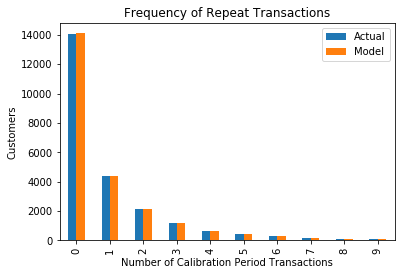

In [36]:
plot_period_transactions(bgf,max_frequency=10);

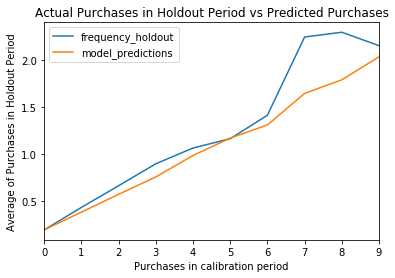

In [37]:
holdout_data = calibration_and_holdout_data(df, 
                                                   'CustomerID', 
                                                   'Timestamp', 
                                                   calibration_period_end=pd.to_datetime('2017-09-07')) 
bgf.fit(holdout_data['frequency_cal'], holdout_data['recency_cal'], holdout_data['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, holdout_data, n=10)

>The 1st plot shows the expected number of customers that are going to repeat purchase 0, 1, 2, 3 ... 10 times in the future. For each number of repeat purchases, we plot both what the model predicted and what the actual numbers were. As we can see, little to no errors in the fit for up to 10 repeat purchases.

>The model fits well till 6 repurchases and underestimates the expected number in case of higher repurchases. This maybe due to less number of customers(~3.5%) with more than 6 repurchases.

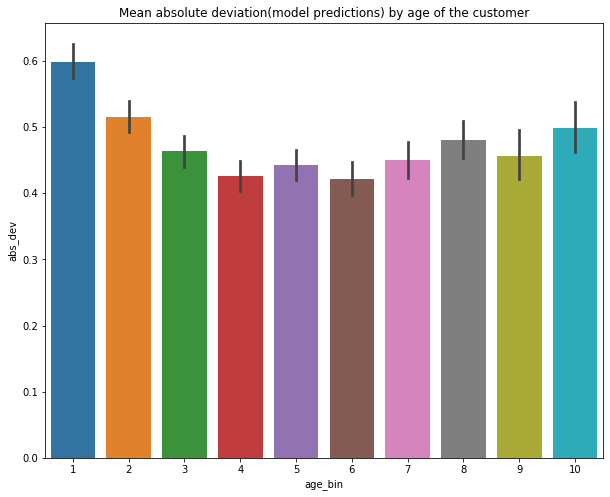

In [38]:
duration_holdout=90
holdout_data["model_predictions"] = bgf.conditional_expected_number_of_purchases_up_to_time(duration_holdout, 
                                                                                              holdout_data["frequency_cal"], 
                                                                                              holdout_data["recency_cal"], 
                                                                                              holdout_data["T_cal"])
temp = holdout_data.reset_index().copy()
temp['abs_dev'] = abs(temp['frequency_holdout']-temp['model_predictions'])
temp['se'] = (temp['frequency_holdout']-temp['model_predictions'])**2
temp['age_bin'] = pd.qcut(temp["T_cal"], 10, retbins=False, labels=np.arange(1, 11, 1))

plt.figure(figsize=(10,8));
sns.barplot(x='age_bin',y='abs_dev',data=temp);
plt.title('Mean absolute deviation(model predictions) by age of the customer');

> Looking at the plot, the MAD for the model increases for new customers. This could be due to lack of data for customers who just started purchasing or maybe there is diffrence in the characterstics between the new and old customers.

# Things to consider

>As we saw from the calibration/holdout analysis, the model performance decrease for customers who made more than 6,7.. repurchases and for customers who are relatively new. These could be due to lack of data, which case we need to wait till some time to build history and use the model for prediction. Other ideas, I can think of to improve our prediction for CLV:
>* We might want to segment customers based on when they were acquired and model them separately. This would address the problem if there is a shift in type of customers buying from our website. 
>* More comprehensive approach would be to enrich our features set. BG/NBD model uses just recency,frequency metrics to predict the customer behaviour, but there could be other covariates like customer reviews/complaints, demographics, online behaviours, product features, marketing activities(promotion etc) that can explain customer characterstics better. These features can be either used in combination with RFM metrics to model CLV (supervised/ML model). Or We could use these features to segment customers and then apply probabilistic models.

# Evaluation Metrics

> Using both the models, We can bin the customers into 4 buckets as mentioned in the question. Then using a holdout/validation data we can compare the actual number of churned customers vs model predicted churn rates in each bucket. Then we can compare the misclassification rates for both the models  in each bucket. We can add up the misclassfication counts to get to one number that compares the two models.

# Mock up comparison

In [39]:
results_df = pd.DataFrame({'Bucket':['highly unlikely to buy','unlikely to buy','likely to buy','highly likely to buy'],
                          'churn_prob':['80-100%','40-80%','20-40%','0-20%'],
                           'expected_churn_rate':[90,60,30,10],
                          'Number of customers in bin (model1)':[70,25,3,2],
                           'Churned customers in bin (model1)':[65,19,1,0],
                           'Churn rate (model1)':[93,76,33,0],
                          'Number of customers (model2)':[30,30,20,20],
                          'Churned customers in bin (model2)':[30,30,0,15],
                           'Churn rate (model2)':[100,100,0,75],
                          'misclassification_rate (model1)':[3,16,3,10],
                          'misclassification_rate (model2)':[10,40,30,65]})
display_df = results_df.T

In [40]:
def highlight_rows(s):
    
    is_row=[]
    for rowname in s.index.tolist():
        if rowname in ['expected_churn_rate','Churn rate (model1)','Churn rate (model2)',
                        'misclassification_rate (model1)','misclassification_rate (model2)']:
            is_row.append(1)
        else:
            is_row.append(0)
    return ['background-color: yellow' if v else '' for v in is_row]

def highlight_1(s):
    is_green = s.index.get_level_values(0) == 'misclassification_rate (model1)'
    return ['color: green' if v else '' for v in is_green]

def highlight_2(s):
    is_red = s.index.get_level_values(0) == 'misclassification_rate (model2)'
    return ['color: red' if v else '' for v in is_red]

display_df = display_df.style.apply(highlight_rows).apply(highlight_1).apply(highlight_2)
display_df

,0,1,2,3
Bucket,highly unlikely to buy,unlikely to buy,likely to buy,highly likely to buy
churn_prob,80-100%,40-80%,20-40%,0-20%
expected_churn_rate,90,60,30,10
Number of customers in bin (model1),70,25,3,2
Churned customers in bin (model1),65,19,1,0
Churn rate (model1),93,76,33,0
Number of customers (model2),30,30,20,20
Churned customers in bin (model2),30,30,0,15
Churn rate (model2),100,100,0,75
misclassification_rate (model1),3,16,3,10


>Misclassification rate for each bin would be the difference between predicted churn rate from model and actual chrun rate realised. An example comparison is shown below. Here, **Model1** is shown to perform *better* than **model2.** 

>There are other classic metrics for comparing the probabilities/classification results from two models, mainly **F1 score and Matthew correlation coefficient**. Both these metrics take precision and recall into consideration. The other advantage is that you get one number to compare models.
> In case of **F1 scores**, since the model outputs probabilities, we can calculate Area under Precision-Recall curve which is nothing but plotting precision & recall for all values of threshold and getting the area. The model with higher area is better.

# Use CLV models for Churn

>Assuming the customers who didn't make a repurchase after calibration period as churned customers, we can measure how well our model is performing using the misclassification, AUC and PR metrics as follows

In [41]:
temp['probability_alive'] = bgf.conditional_probability_alive(holdout_data['frequency_cal'], holdout_data['recency_cal'], holdout_data['T_cal'])
temp['probability_churn'] = 1 - temp['probability_alive']
labels = ["[{0} - {1})".format(i, i + 10) for i in range(0, 100, 10)]
temp['churn_bucket'] = pd.cut(x=temp['probability_churn'], bins=10, labels=labels)
temp['actually_churned'] = np.where(temp['frequency_holdout']==0,1,0)

churn_df = temp.groupby('churn_bucket').agg({'probability_churn':'count','actually_churned':'sum'}).reset_index()
churn_df.columns = ['churn_bucket','number_of_customers','churned_customers']
churn_df['actual_pct_churned'] = round(100*churn_df['churned_customers']/churn_df['number_of_customers'])
churn_df['model_pct_churned'] = np.arange(5,100,10)
churn_df

,churn_bucket,number_of_customers,churned_customers,actual_pct_churned,model_pct_churned
0,[0 - 10),64,5,8.0,5
1,[10 - 20),704,247,35.0,15
2,[20 - 30),1679,895,53.0,25
3,[30 - 40),3243,2306,71.0,35
4,[40 - 50),4639,3747,81.0,45
5,[50 - 60),5244,4424,84.0,55
6,[60 - 70),2600,2189,84.0,65
7,[70 - 80),490,381,78.0,75
8,[80 - 90),215,156,73.0,85
9,[90 - 100),80,63,79.0,95


>It looks like model is not able to differentiate high risk and low risk customers (Two-thirds of our customers have churn probability assigned in the 30-70 % range).

In [42]:
temp['predicted_holdout'] = np.round(temp['probability_churn'])
pd.crosstab(temp['actually_churned'],temp['predicted_holdout'])

predicted_holdout,0.0,1.0
actually_churned,,
0,3066,1479
1,6890,7523


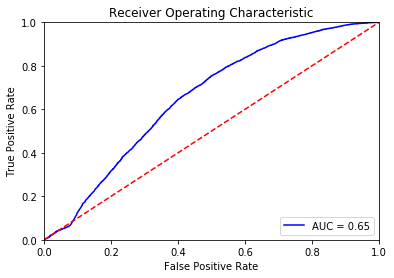

In [43]:
# auc curve

# calculate the fpr and tpr for all thresholds of the classification
y_true = temp.actually_churned
y_pred = temp.probability_churn
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

> Our conclusion from binning of probabilities is reinforced by AUC score of 0.65. AUC score implies the probability of randomly picked positive class (here,churned customer) has a high score than picked negative class (customer not churned). In other words, how well our model separates those who churned or not churned.

In [44]:
print(classification_report(y_true,np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.31      0.67      0.42      4545
           1       0.84      0.52      0.64     14413

   micro avg       0.56      0.56      0.56     18958
   macro avg       0.57      0.60      0.53     18958
weighted avg       0.71      0.56      0.59     18958



> F1 score at a threshold of 0.5, is around 0.56. The precision for not churned is only 0.31. This might be due to the way we defined the label who churned. We can find the best threshold that increases f1 score, it is somewhere around 0.25. So, if model predicts a probability greater than 0.2-0.25 then the customer is highly likely to be churned. 

In [45]:
f1={}
thresholds = np.arange(0,1,0.025)
for threshold in thresholds:
    preds = [0 if p <threshold  else 1 for p in y_pred]
    score = f1_score(y_true, preds,average='micro')
    f1[threshold]=score
#plt.plot(*zip(*sorted(f1.items())))
#plt.show()
print(f"Best threshold with maximum f1 score: {max(f1, key=lambda k: f1[k])}")

Best threshold with maximum f1 score: 0.2
